In [1]:
#%% Set up and load data
import brightway2 as bw
import seaborn as sb
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Set working directory
path = "."
os.chdir(path)
absolute_path = os.path.abspath(path)

# Set project
bw.projects.set_current("Geothermal")

# Method 
ILCD_CC = [method for method in bw.methods if "ILCD 2.0 2018 midpoint no LT" in str(method) and "climate change total" in str(method)]

# Carbon footprints from literature
cge_cfs=pd.read_excel(os.path.join(absolute_path, "data_and_models/Carbon footprints from literature.xlsx"), sheet_name="Conventional", index_col=None, skiprows=1)
cge_cfs=cge_cfs.drop(columns=["Technology", "Notes", "Operational CO2 emissions (g/kWh)"])
cge_cfs.columns= ["study", "carbon footprint"]

ege_cfs=pd.read_excel(os.path.join(absolute_path, "data_and_models/Carbon footprints from literature.xlsx"), sheet_name="Enhanced", index_col=None, skiprows=1)
ege_cfs=ege_cfs.drop(columns=["Technology", "Notes", "Diesel consumption (GJ/m)", "Installed capacity (MW)"])
ege_cfs.columns= ["study", "carbon footprint"]

# Reference model carbon footprints
n_iter = 10000
ecoinvent_version = "ecoinvent_3.6"
folder_IN = os.path.join("generated_files", ecoinvent_version, "validation")
file_name="ReferenceVsLiterature CC N" + str(n_iter)

cge_ref_df = pd.read_json(os.path.join(absolute_path, folder_IN, file_name + " - Conventional"))
ege_ref_df = pd.read_json(os.path.join(absolute_path, folder_IN, file_name + " - Enhanced"))

In [28]:
def compute_chi2(obs, exp, n_bins=10, c=0, p = 0.9):
    '''
    obs = literature data
    exp = distribution data, against which we are testing
    '''
    
    import matplotlib.pyplot as plt
    bins_count, bins_pos, _ = plt.hist(exp, n_bins)
    E = np.cumsum(bins_count)
    
    bins_count_obs = np.zeros(n_bins)
    for i in range(n_bins):
        obs_greater = obs[obs >= bins_pos[i]]
        bins_count_obs[i] = np.sum(obs_greater < bins_pos[i+1])
    O = bins_count_obs
    
    chi2_calc = sum((O-E)**2 / E)
    
    # Chi-Squared Percent Point Function
    from scipy.stats import chi2
    # Define probability
    k = np.sum(O>0)
    df = k-c # degrees of freedom    
    # retrieve value <= probability
    chi2_critical = chi2.ppf(p, df)
    
    print('chi2_calculated: ' + str(chi2_calc))
    print('chi2_critical: ' + str(chi2_critical))
    if chi2_calc >= chi2_critical:
        print('Hypothesis is rejected')
    else:
        print('Hypothesis is accepted')
        
    return E,O,chi2_calc

chi2_calculated: 173679.00552356394
chi2_critical: 12.017036623780532
Hypothesis is rejected


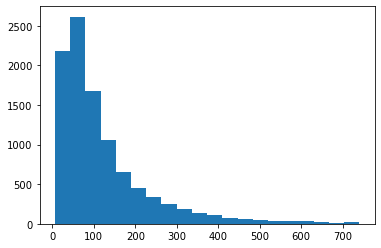

In [29]:
# cge
expected = cge_ref_df.values
observed = cge_cfs['carbon footprint'].values
E,O,chi2_calc = compute_chi2(observed, expected, n_bins=20)

chi2_calculated: 18.86983812200262
chi2_critical: 4.605170185988092
Hypothesis is rejected


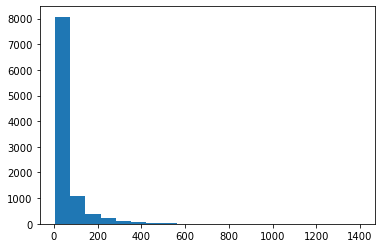

In [24]:
# ege
expected = ege_ref_df.values
observed = ege_cfs['carbon footprint'].values
chi2_calc_cge = compute_chi2(observed, expected, n_bins=20)

In [26]:
import scipy

In [27]:
scipy.stats.kstest(E,O)

TypeError: 'numpy.ndarray' object is not callable